In [1]:
import numpy as np
from matplotlib import pyplot as plt
from utils import *
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.preprocessing import MinMaxScaler

In [2]:
''' 
    Read one week of data 
'''
week = 1

# Format the week with leading zeros
number = f"{week:02d}"

# Path of file
base_path = f"data/X{number}/X{number}"

# Load file
data = np.loadtxt(base_path)

# Keep first 144 entries from each line 
data = data[:, :144]

### Train a NN to approximate the MLU

In [4]:
# Normalize the data
scaler = MinMaxScaler()
data_norm = normalize_matrix(scaler, data)

# Train-Test Split 
train_data, test_data = train_test_split(data_norm, 0.8)

In [6]:
# Create a labeled dataset of (TM, u)

# Get u values on training data
G = abilene_topo_lossfn()

mlu_train_labels = np.empty((1, len(train_data)))

for i in range(len(train_data)):

    D = train_data[i, :].reshape(12,12)
    np.fill_diagonal(D, 0)

    u = MinMaxLinkUtil(G, D)
    mlu_train_labels[0,i] = u
    
np.save('mlu_train_labels.npy', mlu_train_labels)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-09-10


In [30]:
# Get u values for testing data labels 
# Get u values on training data
G = abilene_topo_lossfn()

mlu_test_labels = np.empty((len(test_data), ))

for i in range(len(test_data)):

    D = test_data[i, :].reshape(12,12)
    np.fill_diagonal(D, 0)

    u = MinMaxLinkUtil(G, D)
    mlu_test_labels[i] = u
    
np.save('mlu_test_labels.npy', mlu_test_labels)


In [13]:
input_size = train_data.shape[1] # Number of features in input
output_size = 1  # Number of output classes 
learn_rate = 0.001 
epochs = 100
batch_size = 32
shuffle = False #don't want to lose the time dependency
num_workers = 4  # Number of subprocesses to use for data loading

In [23]:
# Create a dataset with mlu_train_labels as the labels for each corresponding traffic matrix 


train_dataset = torch.utils.data.TensorDataset(torch.FloatTensor(train_data),
                                                 torch.Tensor(mlu_train_labels.reshape(-1)))


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                             num_workers=num_workers,
                                             shuffle=shuffle)


In [15]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(144, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)  # Output layer for scalar value

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)  # No activation function for output
        return x


In [26]:
def train(model, train_loader, criterion, optimizer, num_epochs=100):
    model.train()
    track_losses = np.zeros(epochs)
    for epoch in range(num_epochs):
        for inputs, labels in train_loader:
            optimizer.zero_grad()  # Clear previous gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs.squeeze(), labels)  # Calculate loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights

        track_losses[epoch] = loss.item()
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():10.4e}')
    
    return track_losses

In [70]:
def evaluate_model(model, test_loader, criterion, mlu_test_labels):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    model_outputs = torch.zeros((mlu_test_labels.shape))

    start_idx = 0
    end_idx = start_idx + 32
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(test_loader):    
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            total_loss += loss.item()
            
            model_outputs[start_idx:end_idx] = outputs.squeeze()
            start_idx += (outputs.shape[0])
            end_idx = start_idx + outputs.shape[0]

    average_loss = total_loss / len(test_loader)
    print(f'Average Test Loss: {average_loss:10.4e}')

    return model_outputs

In [27]:
model = MLP()
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
track_losses = train(model, train_loader, criterion, optimizer)

Epoch [10/100], Loss: 3.0462e-04
Epoch [20/100], Loss: 5.9261e-05
Epoch [30/100], Loss: 2.5495e-05
Epoch [40/100], Loss: 1.4980e-05
Epoch [50/100], Loss: 1.7323e-05
Epoch [60/100], Loss: 1.4746e-05
Epoch [70/100], Loss: 1.4596e-03
Epoch [80/100], Loss: 2.0530e-05
Epoch [90/100], Loss: 2.9818e-06
Epoch [100/100], Loss: 1.4473e-05


Text(0.5, 1.0, 'Training Loss vs. Epochs: 2 Layer FFNN (144-128-64-1) w/ Linear Layer Activation')

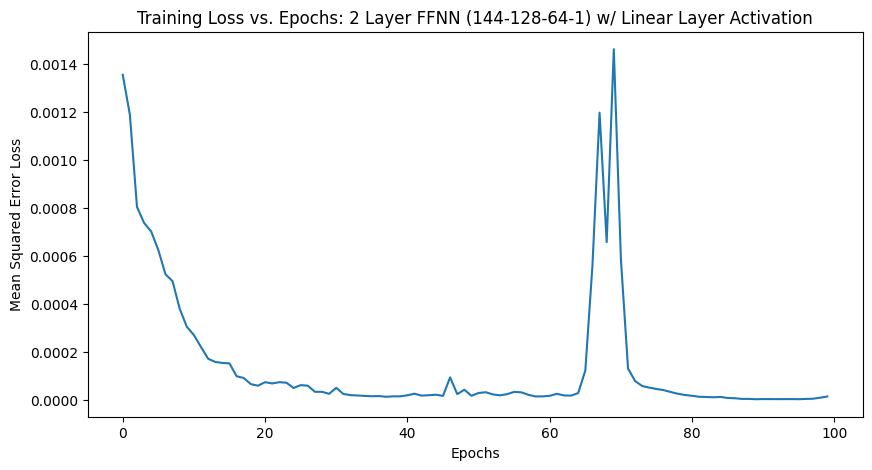

In [28]:
# Plot training loss 
fig, ax = plt.subplots(figsize = (10,5))
ax.plot(range(epochs), track_losses)

# Label Figure
ax.set_xlabel('Epochs')
ax.set_ylabel('Mean Squared Error Loss')
ax.set_title('Training Loss vs. Epochs: 2 Layer FFNN (144-128-64-1) w/ Linear Layer Activation')

In [31]:
test_dataset = torch.utils.data.TensorDataset(torch.FloatTensor(test_data),
                                                 torch.Tensor(mlu_test_labels))


test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                             num_workers=num_workers,
                                             shuffle=shuffle)


In [71]:
# Evaluate the model
model_outputs = evaluate_model(model, test_loader, criterion, mlu_test_labels)

Average Test Loss: 1.8075e-04


Text(0.5, 1.0, 'Model Output vs. Testing Labels: 2 Layer FFNN (144-128-64-1) w/ Linear Layer Activation')

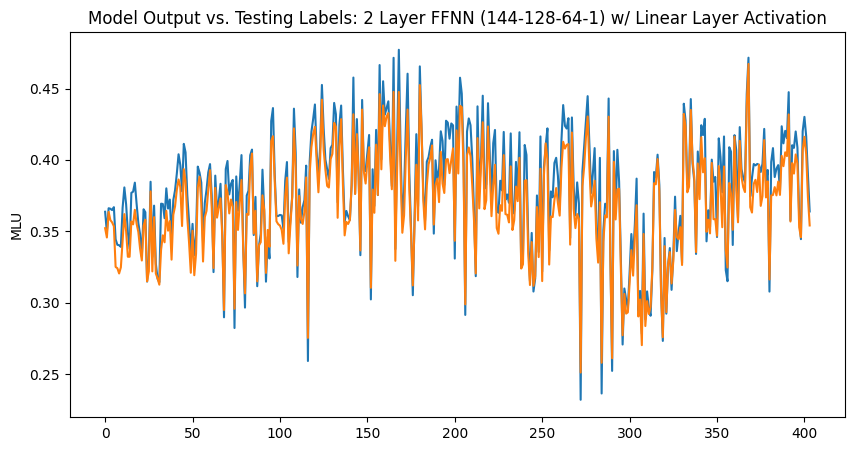

In [72]:
# plot test labels vs. outputs 
fig, ax = plt.subplots(figsize = (10,5))
ax.plot(mlu_test_labels)
ax.plot(model_outputs)

# Label Figure
ax.set_ylabel('MLU')
ax.set_title('Model Output vs. Testing Labels: 2 Layer FFNN (144-128-64-1) w/ Linear Layer Activation')

In [73]:
# save model outputs for u 
np.save('mlu_approx.npy', model_outputs)

In [107]:
# save model 
PATH = 'mlu_NN_approx.pth'
torch.save(model.state_dict(), PATH)

### Train Predictor on 'Naive' Loss Function

In [74]:
''' 
    Read one week of data 
'''
week = 1

# Format the week with leading zeros
number = f"{week:02d}"

# Path of file
base_path = f"data/X{number}/X{number}"

# Load file
data = np.loadtxt(base_path)

# Keep first 144 entries from each line 
data = data[:, :144]

In [75]:
# Normalize the data
scaler = MinMaxScaler()
data_norm = normalize_matrix(scaler, data)

# Train-Test Split 
train_data, test_data = train_test_split(data_norm, 0.8)

# Window the dataset
trainX, trainY = create_dataset(train_data, 10)
testX, testY = create_dataset(test_data, 10)

In [76]:
# Specify model parameters 
input_size = trainX.shape[2] # Number of features in input
hidden_size = 200  # Number of features in hidden state
output_size = 144  # Number of output classes 
learn_rate = 0.001 
epochs = 100
num_layers = 1
batch_size = 32
shuffle = False #don't want to lose the time dependency
num_workers = 4  # Number of subprocesses to use for data loading

In [77]:
# create torch datasets and torch dataloader

train_dataset = torch.utils.data.TensorDataset(torch.FloatTensor(trainX),
                                                 torch.Tensor(trainY))


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                             num_workers=num_workers,
                                             shuffle=shuffle)

test_dataset  = torch.utils.data.TensorDataset(torch.FloatTensor(testX),
                                                 torch.Tensor(testY))


test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1,
                                             num_workers=num_workers,
                                             shuffle=shuffle)


In [78]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(RNN, self).__init__()

        self.rnn = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
        )
        self.sigmoid = nn.Sigmoid()
        self.out = nn.Linear(hidden_size, input_size)

    def forward(self, x):
        # x shape (batch, time_step, input_size)
        # r_out shape (batch, time_step, output_size)
        # h_n shape (n_layers, batch, hidden_size)
        # h_c shape (n_layers, batch, hidden_size)
        r_out, _ = self.rnn(x, None)  # None represents zero initial hidden state
        out = self.out(r_out[:, -1, :])  # return the last value
        out = self.sigmoid(out)
        return out

In [110]:
import time

# Define training function

def train(model, train_loader, epochs, criterion, optimizer, mlu_train_labels, model_approx):
    ''' Train ML Model''' 

    track_losses = np.zeros(epochs)
    u = torch.FloatTensor(mlu_train_labels[10:])

    for epoch in range(epochs): 
        start_idx = 0 
        end_idx = start_idx+32
        for idx, (inputs, _) in enumerate(train_loader): 
            
            # Pass data to LSTM
            optimizer.zero_grad()
            outputs = model(inputs) # Get Outputs

            # Pass outputs to NN aproximator 
            u_prime = model_approx(outputs)
            
            # Compute the loss between u_prime and u
            target_u = u[start_idx:end_idx]
            loss = criterion(u_prime.squeeze(), target_u) #mse loss
            
            start_idx += u_prime.shape[0] 
            end_idx = start_idx + u_prime.shape[0]

            # Compute the gradient and update the network parameters
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        training_loss = loss.item()
        track_losses[epoch] = training_loss 

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():10.4e}')

    return track_losses

In [108]:
# Call model
predictor = RNN(input_size, hidden_size, num_layers)

# Create optimizer 
optimizer = optim.Adam(predictor.parameters(), lr=learn_rate)

# Create loss function
criterion = nn.MSELoss()

In [111]:
# Train the model
loss = train(predictor, train_loader, epochs, criterion, optimizer, mlu_train_labels.reshape(-1), model)

Epoch [10/100], Loss: 2.8929e-04
Epoch [20/100], Loss: 1.0004e-04
Epoch [30/100], Loss: 1.1502e-05
Epoch [40/100], Loss: 1.9267e-05
Epoch [50/100], Loss: 6.5470e-06
Epoch [60/100], Loss: 6.1355e-06
Epoch [70/100], Loss: 5.0733e-06
Epoch [80/100], Loss: 7.5891e-06
Epoch [90/100], Loss: 1.7912e-05
Epoch [100/100], Loss: 8.9947e-06


In [112]:
PATH = 'classical_loss_function.pth'
torch.save(predictor, PATH)

Text(0.5, 1.0, 'Training Loss vs. Epochs')

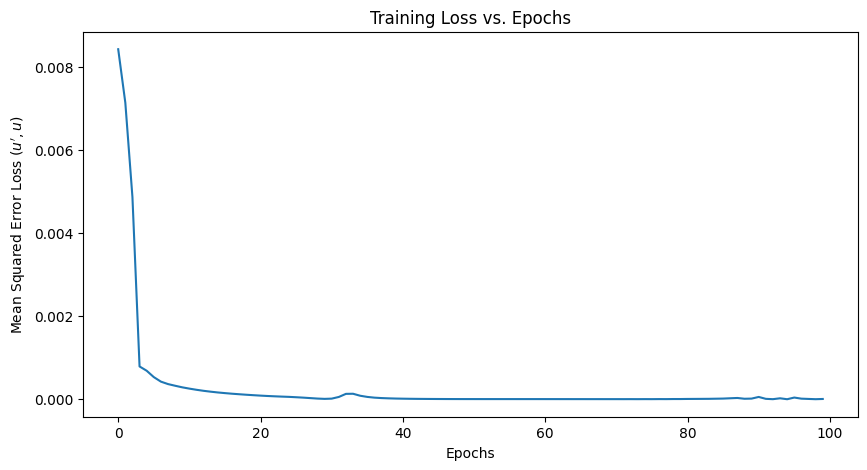

In [115]:
# Plot the training loss 
# Plot training loss 
fig, ax = plt.subplots(figsize = (10,5))
ax.plot(range(epochs), loss)

# Label Figure
ax.set_xlabel('Epochs')
ax.set_ylabel(r'Mean Squared Error Loss: $(u^{\prime}, u)$')
ax.set_title('Training Loss vs. Epochs')

In [123]:
# Evaluate the predictor 
def evaluate_predictor(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    model_outputs = np.zeros((testY.shape[0], testY.shape[1]))

    start_idx = 0
    end_idx = start_idx + 32
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(test_loader):    
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            model_outputs[start_idx:end_idx, :] = outputs.squeeze()
            start_idx += (outputs.shape[0])
            end_idx = start_idx + outputs.shape[0]

    average_loss = total_loss / len(test_loader)
    print(f'Average (Normalized) Test Loss: {average_loss:10.4e}')

    return model_outputs

In [124]:
model_outputs = evaluate_predictor(predictor, test_loader, criterion)

C:\Users\marth\AppData\Local\Temp\ipykernel_7508\38854697.py:15: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  model_outputs[start_idx:end_idx, :] = outputs.squeeze()


Average (Normalized) Test Loss: 2.8569e-01


In [126]:
# Use test data from the original dataset. We can do the inverse transform, but it won't be 100% accurate. 
_, test_set = train_test_split(data, 0.8)

preds = np.empty(model_outputs.shape)

for i in range(len(test_set)-10):
    scaler = MinMaxScaler()
    _ = scaler.fit_transform(test_set[i, :].reshape(-1, 1))

    preds[i, :] = scaler.inverse_transform(model_outputs[i,:].reshape(1, -1))


# Save predictions 
np.save('preds_abilene_classical_loss.npy', preds)

Text(440, 50, 'NMSE: 4.318')

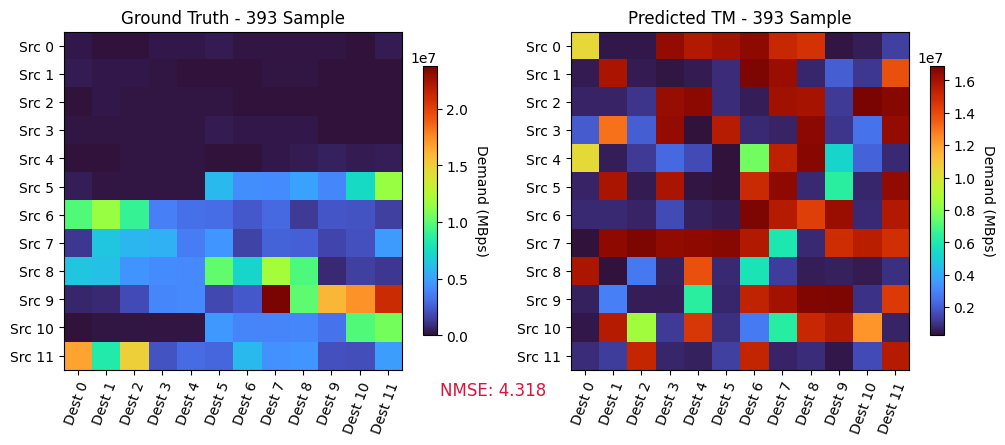

In [127]:
# Visual comparison of model outputs and ground truth
sources = ['Src {}'.format(i) for i in range(0,12)]
destinations = ['Dest {}'.format(i) for i in range(0,12)]

sample_number = 393

# Create a heatmap
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols=2, figsize = (12,5))
im1 = ax1.imshow(np.reshape(test_set[sample_number+10, :], (12,12)), cmap = 'turbo') #scaled ground truth

# Create colorbar
cbar = ax1.figure.colorbar(im1, ax=ax1, shrink = 0.7)
cbar.ax.set_ylabel('Demand (MBps)', rotation=-90, va="bottom")

# Show all ticks and label them with the respective list entries
ax1.set_xticks(np.arange(len(destinations)), labels=destinations)
ax1.set_yticks(np.arange(len(sources)), labels=sources)

# Rotate the tick labels and set their alignment.
plt.setp(ax1.get_xticklabels(), rotation=70, ha="right",
         rotation_mode="anchor")


ax1.set_title("Ground Truth - %d Sample" % sample_number)

im2 = ax2.imshow(np.reshape(preds[sample_number, :], (12,12)), cmap = 'turbo') #scaled prediction

# Create colorbar
cbar = ax2.figure.colorbar(im2, ax=ax2, shrink = 0.7)
cbar.ax.set_ylabel('Demand (MBps)', rotation=-90, va="bottom")

# Show all ticks and label them with the respective list entries
ax2.set_xticks(np.arange(len(destinations)), labels=destinations)
ax2.set_yticks(np.arange(len(sources)), labels=sources)

# Rotate the tick labels and set their alignment.
plt.setp(ax2.get_xticklabels(), rotation=70, ha="right",
         rotation_mode="anchor")


ax2.set_title("Predicted TM - %d Sample" % sample_number)

# Compute normalized mean squared error 
actual = test_set[sample_number+10, :]
predicted = preds[sample_number, :]

mse = sum([(a - p) ** 2 for a, p in zip(actual, predicted)]) / len(actual)
mean_actual = sum(actual) / len(actual)
normalization_factor = sum([(a - mean_actual) ** 2 for a in actual]) / len(actual)
nmse = mse / normalization_factor

plt.annotate('NMSE: %0.3f' % nmse, 
            xy = (440, 50), xycoords='figure pixels', color = 'crimson',
            fontsize = 12)

In [128]:
# Compute the MLU on the predictions 
G = abilene_topo()
mlu_classical = np.empty((1, len(preds)))
for i in range(len(preds)):

    D = preds[i, :].reshape(12,12)
    np.fill_diagonal(D, 0)

    u = MinMaxLinkUtil(G, D*0.01)
    mlu_classical[0,i] = u


# Save MLU on predictions
np.save('mlu_classical.npy', mlu_classical)

Text(0.5, 1.0, 'MLU Baseline vs. MLU Prediction')

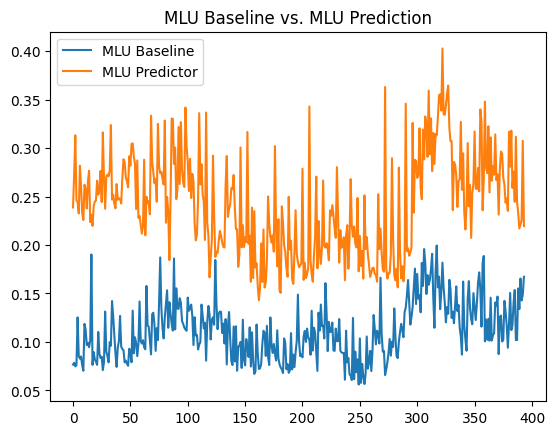

In [130]:
mlu_baseline = np.load('MLUS/mlu_abilene_baseline.npy')

plt.plot(mlu_baseline.reshape(-1,1), label = 'MLU Baseline')
plt.plot(mlu_classical.reshape(-1,1), label = 'MLU Predictor')
plt.legend()
plt.title('MLU Baseline vs. MLU Prediction')

Text(0.5, 1.0, 'CDF of MLU Bias -  $\\frac{U^{\\prime}}{U}$ $MSE(U^{\\prime}, U)$ Loss Function')

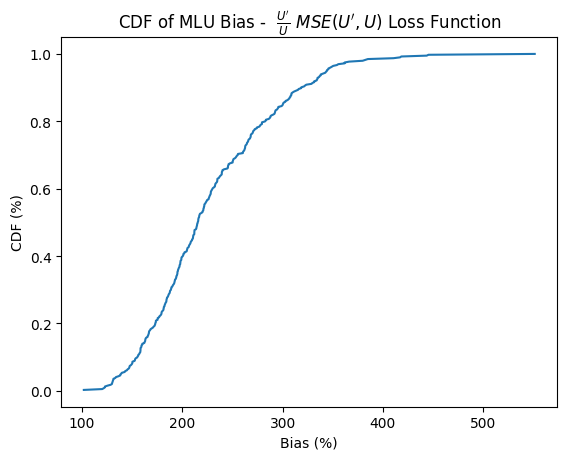

In [132]:
bias = mlu_classical/mlu_baseline
data_size = len(bias)

data = np.reshape(bias*100, (394,))

data_set = sorted(set(data))
bins = np.append(data_set, data_set[-1] + 1)

# Use the histogram function to bin the data
counts, bin_edges = np.histogram(data, bins=bins, density=False)
counts = counts.astype(float) / data_size

# Find the cdf
cdf = np.cumsum(counts*100)
plt.plot(bin_edges[0:-1], cdf/np.max(cdf))
plt.xlabel('Bias (%)')
plt.ylabel('CDF (%)')
plt.title(r'CDF of MLU Bias -  $\frac{U^{\prime}}{U}$ $MSE(U^{\prime}, U)$ Loss Function')

In [131]:
# Compute the MLU on the predictions 
G = abilene_topo_lossfn()
mlu_classical_normalized = np.empty((1, len(preds)))
for i in range(len(preds)):

    D = model_outputs[i, :].reshape(12,12)
    np.fill_diagonal(D, 0)

    u = MinMaxLinkUtil(G, D)
    mlu_classical_normalized[0,i] = u

Text(0.5, 1.0, 'MLU Baseline vs. MLU Prediction -- Normalized Output')

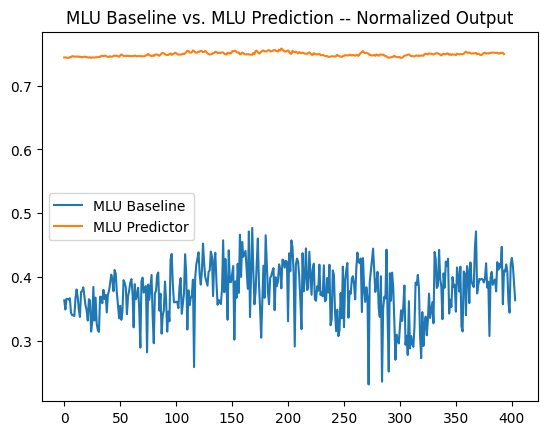

In [134]:
mlu_baseline = np.load('MLUS/mlu_abilene_baseline.npy')

plt.plot(mlu_test_labels.reshape(-1,1), label = 'MLU Baseline')
plt.plot(mlu_classical_normalized.reshape(-1,1), label = 'MLU Predictor')
plt.legend()
plt.title('MLU Baseline vs. MLU Prediction -- Normalized Output')